## Comparing Wildfire Occurence Rates and Density between New Mexico Climate Zones.

As Antropogenic Climate Change continues its course, one of the key phenemonen that it affects is the rate and size of wildfires.  While wildfires are a natural process essential to the health of an ecosystem, an unprecedented increase in number and severity can have several deleterious effects to both natural habitats and human developments.

For this study, we will compare the different Climate Zones in the state of New Mexico to compare the rate of wildfire incidents since 1992. As the factors that contribute to wildfire formation and growth are heavily variant depending on local climate, which in itself will undoubtedly shift as a result of antropogenic climate change, then observerd trends may allow us to forecast future event probabilites. 

In [1]:
# Standard Libraries
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

# Third party Libraries
import earthpy as et
import geodatasets as gds
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import pandas as pd
import pyogrio
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

The Climate Zone dataset for the Contiguous United States is computed from station data throughout the 20th Century onward and uses a 5 km gridded range to compute  average termperature and precipitations values throughout regitions of the continental US.  It encompasses 344 separate climate divisons with average computed from daily meteological data provided by weather stations.  For this analysis, only the 8 climate divisons in New Mexico are used. 

National Centers for Environmental Information. (2023). CONUS Climate Division Dataset (Version: nClimDiv) https://doi.org/10.7289/V5M32STR NCEI. https://www.ncei.noaa.gov/

### Importing Analysis Site

After importing all relevant libraries and modules, we must import the shapefile for the area of analysis and trim it to only show relevant areas. IN this case, only the rows for New Mexico are retained, and the name of the climate zone and the geometry are kept as columns. We then plot the resulting rows with a legend to identify the designations of the areas of study.

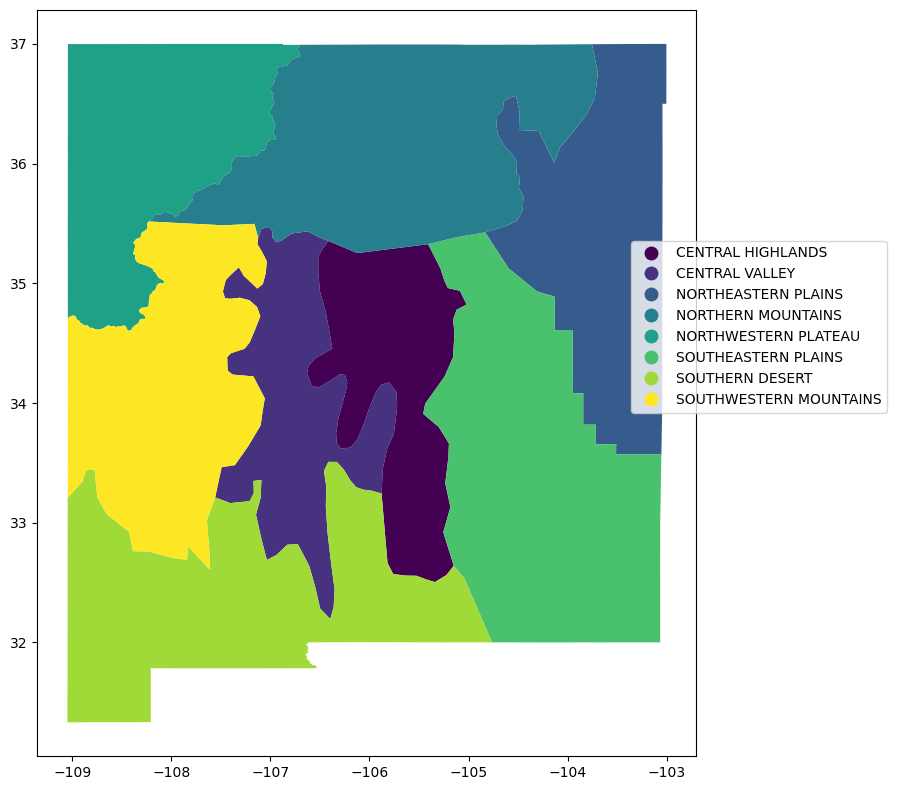

In [2]:
# Import climate zone shapefile and create geodataframe
climate_zone_url = ('https://www.ncei.noaa.gov/pub/data/cirs/climdiv/'
                    'CONUS_CLIMATE_DIVISIONS.shp.zip')
CONUS_climate_dl_path = et.data.get_data(url = climate_zone_url)

US_climate_zone_gdf = gpd.read_file(CONUS_climate_dl_path)

# Create new gdf w/ only NM climates and trim columns
NM_climates_gdf = US_climate_zone_gdf[US_climate_zone_gdf['STATE'] == 'New Mexico']

NM_climates_gdf = (
    NM_climates_gdf[['STATE', 'NAME', 'geometry']]
    .set_index('STATE')
    .to_crs(4326))


ax = NM_climates_gdf.plot(column = 'NAME', cmap = 'viridis', legend= True)

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(10, 8)

# Move the legend to the right side
ax.legend_.set_bbox_to_anchor((1.3,0.7))
plt.tight_layout()

### WildFire Data Import

Wildfire data from the USDA is imported through earthpy, and given a path designation and converted into a geodataframe.  From there, only the relevant columnsn for ID, date, size, and geoemtery are kept and the coordinate reference system from the prior dataset is passed to this geodataframe.  Then the rows are trimmed to only inlcude fires within New Mexico. 

This data represents an amalgramation of 2.3 million wildfire reports within the United states from 1992 to 2022. It correlates the initial discovery location, the final size of the fire, and a precise point location for each incident as well as links wider operation and reporting information for each event. 

Short, Karen C. 2022. Spatial wildfire occurrence data for the United States, 1992-2020 [FPA_FOD_20221014]. 6th Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2013-0009.6

In [3]:
wildfire_url = ('https://www.fs.usda.gov/rds/archive/products/'
                'RDS-2013-0009.6/RDS-2013-0009.6_Data_Format2_GDB.zip')
wildfire_dir = et.data.get_data(url = wildfire_url)

fire_path = os.path.join(wildfire_dir, 
                         'Data', 
                         'FPA_FOD_20221014.gdb')
if not 'fire_gdf' in globals():
    print('fire_gdf does not exist. Loading....')
    fire_gdf = pyogrio.read_dataframe(fire_path, layer='Fires')

NM_fires_gdf = fire_gdf[fire_gdf['STATE'] == 'NM']

# Create new dataframe with relevant columns only
NM_fire_size_gdf = (
    NM_fires_gdf[['FOD_ID', 'DISCOVERY_DATE', 'FIRE_SIZE', 'geometry']]
              .set_index('FOD_ID'))

# Set Discovery Date value to datetime64
NM_fire_size_gdf.DISCOVERY_DATE = pd.to_datetime(NM_fire_size_gdf.DISCOVERY_DATE)
# Set crs of geodataframe to same as climate zone gdf
NM_fire_size_gdf = NM_fire_size_gdf.to_crs(NM_climates_gdf.crs)

NM_fire_size_gdf

fire_gdf does not exist. Loading....


,DISCOVERY_DATE,FIRE_SIZE,geometry
FOD_ID,,,
20,2004-06-04,0.10,POINT (-105.72055 33.44083)
21,2004-06-19,0.10,POINT (-105.62860 33.30721)
22,2004-06-21,0.10,POINT (-105.76805 33.44444)
23,2004-06-25,0.10,POINT (-105.76610 33.55944)
24,2004-07-01,0.25,POINT (-105.52610 33.30805)
...,...,...,...
400635292,2020-05-25,1.00,POINT (-108.41930 32.62520)
400635295,2020-07-14,0.10,POINT (-108.90240 31.73078)
400635299,2020-06-15,293.00,POINT (-109.00640 31.75032)


### Joining and Aggregating Data

Next we join the two geodataframes so that the aggreagated fires are collected according to which region their point data exists in.  Fires are grouped by climate region, then the maximum value for fire acreage and the number of fires for each fire year are counted and added in. Then we divide the study ara into millions of hectares in order to calculate the number of fires per unit of area for the final chloropleth map.

In [4]:
NM_fire_region_gdf = (
    NM_climates_gdf
    [['NAME', 'geometry']]
    .sjoin(NM_fire_size_gdf, how = 'inner', predicate = "intersects")
)
NM_fire_region_gdf = (
    NM_fire_region_gdf
    .groupby(['NAME', NM_fire_region_gdf.DISCOVERY_DATE.dt.year])
    .agg(
        max_fire_size=('FIRE_SIZE', 'max'),
        num_fires=('index_right', 'count')
    )
)

NM_fire_region_gdf

max_fire_size  num_fires
NAME                   DISCOVERY_DATE                          
CENTRAL HIGHLANDS      1992                     26.0        105
                       1993                   5350.0        208
                       1994                  10000.0        338
                       1995                   1600.0        209
                       1996                   8260.0        295
...                                              ...        ...
SOUTHWESTERN MOUNTAINS 2016                  42102.0        202
                       2017                  20501.0        115
                       2018                  50296.0        181
                       2019                   5162.0        130
                       2020                  25950.0        144

[232 rows x 2 columns]

In [5]:
# Reproject watershed DF to Albers EA and report area in millions of 
# hectares w/ geometry
NM_climates_gdf['area_ha'] = (
    NM_climates_gdf.to_crs(9822).area 
    # Convert to hectares
    / 10000
    # Convert to millions of hectares
    /1000000
)

(
    NM_climates_gdf
    [['NAME', 'area_ha', 'geometry']]
)

# Reset index and display fire count per watershed
NM_fire_count_gdf = (
    NM_fire_region_gdf
    .reset_index()
    [['NAME', 'num_fires']]
    .groupby('NAME')
    .sum()
)

# Add area and geometry data back into dataframe
NM_fire_density_df= (
    NM_climates_gdf
    .set_index('NAME')
    .join(NM_fire_count_gdf)
    [['num_fires', 'area_ha', 'geometry']]
)

# Add column for fires per hectare
NM_fire_density_df['fire_density_per_ha'] = (
    NM_fire_density_df.num_fires / NM_fire_density_df.area_ha)

NM_fire_density_df

,num_fires,area_ha,geometry,fire_density_per_ha
NAME,,,,
CENTRAL VALLEY,3328,2.605538,"POLYGON ((-105.87800 33.24400, -105.98500 33.2...",1277.279227
CENTRAL HIGHLANDS,4978,2.617466,"POLYGON ((-105.14900 32.64000, -105.22300 32.5...",1901.839161
NORTHEASTERN PLAINS,2265,3.868647,"POLYGON ((-104.12943 34.77932, -104.13290 34.8...",585.475996
SOUTHEASTERN PLAINS,5067,5.584829,"POLYGON ((-104.76431 32.00053, -105.03800 32.5...",907.279298
NORTHWESTERN PLATEAU,7357,3.432855,"POLYGON ((-106.96946 37.00011, -106.95281 37.0...",2143.114318
NORTHERN MOUNTAINS,10709,4.970772,"POLYGON ((-104.89187 35.41759, -105.13100 35.3...",2154.393540
SOUTHERN DESERT,1585,4.912759,"POLYGON ((-105.87800 33.24400, -105.81800 32.6...",322.629319
SOUTHWESTERN MOUNTAINS,8247,4.050671,"POLYGON ((-109.04724 33.20878, -109.04712 33.2...",2035.959072


### PLotting time series data by Climate Region.
We generate a series of plots to compare the number of fires and yearly maximum fire size between climate regions in New Mexico.  The plot shows the data for each fire year from 1992 - 2022 and a dropdown on the right side allows the user to view different plots by selecting a different climate region. 

In [6]:
### Plot fire occurrence and size over time for each region


# Set values for ylabels and titles
labels = pd.DataFrame(dict(
    column_name = ['max_fire_size', 'num_fires'],
    ylabel = ['Fire Size (million ha)', 'Number of Fires'],
    title = ['Largest Fire on Record in Region', 
             'Total Number of Fires in Region']))

def fire_plot(region_name, df=NM_fire_region_gdf, labels=labels):
    """
    Create a multi-panel plot for a region

    Parameters
    ----------
    region_name : str
      The name of the region to generate a plot for. Must exists 
      in the 'name' index of df.
    df : pd.DataFrame
      The dataframe with the data to plot. Columns much match
      an item in labels.column_name to be plotted
    labels : pd.DataFrame
      Plot labels. Must have a 'column_name', 'ylabel', and 'title'
      columns with str values. Each row will be a subplot.

    Returns
    -------
    plot : hv.core.layout.Layout
      A holoviews plot layout or similar. For use with hv.DynamicMap.
    """
    # Generate a subplot for each row in the labels
    subplots = []
    # Iterate through the labels row by row
    for i, labs in labels.iterrows():
        # Create subplot
        subplot = (
            df.xs(region_name, level='NAME')
            [[labs.column_name]]
            .hvplot(
                xlabel = 'Year', ylabel = labs.ylabel, title = labs.title,
                width = 1000, color = 'orange', size = 2 
            ))
        subplots.append(subplot)
        

    # Stack the subplots vertically
    plot = hv.Layout(subplots).cols(1)
    return plot

# Create a dropdown menu to switch between regions
(
    hv.DynamicMap(
        # The plotting function for the two-panel fire history
        fire_plot,
        # Define the dimension for the dropdown
        kdims=[('region', 'Region')])
    # Add the explicit indexing - region names as a bokeh dimension
    .redim.values(region=NM_fire_region_gdf.reset_index().NAME)
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3356c517-050e-4b45-8fa2-39ad58de09a5': {'version…

### Fire incidents appear cyclical in abundance, whereas large fires seem to increase majorly after 2010.

Throughout the different climate regions, the number of fires seems to be on a 2-3 year cycle which can be attributed to both precipitation variations and prior burns clearing out potentially flammable brush which takes a few years to regrow.  This cycle seems to be standard for most of the climate regions with the places boasting more mountainous terrain exhibiting higher variability in highs and lows. While some of the. 

In regards to fire size, most of the climate zones seem to show a sporadic number of large events, which seems to rise in occurence from the late 2000's onwards.  Several climate zones also expereinced major fires around the year 2011, which was also the year that two of the largest fires in the states recorded history (Las Conchas and Whitewater-Baldy fires) had occured.  Ongoing droughts most likely contirbuted to these fires, as the climates grew much drier without the amount of seasonal precipitiation that they would normally be getting. 

In [21]:

# Create a simplified geometry column
# NM_fire_density_df = NM_fire_density_df.geometry.simplify(tolerance=0.1)


# Plot the polygons
poly_plot = gv.Polygons(
    NM_fire_density_df.reset_index(),  # Reset the index to include all columns
    # vdims=['fire_density_per_ha', 'name']
).opts(
    width=1000, height=1000,
    colorbar=True, color='fire_density_per_ha',
    cmap='plasma', line_color='white',
    xaxis='bare', yaxis='bare', tools=['hover']
)

# Show the plot
gv.tile_sources.OSM * poly_plot

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (NAME,num_fires,area_ha,fire_density_per_ha)

### Fire Density Much HIgher in Norhtern Part of the State

The North and Northwest parts of New Mexico feature a combination of semi-arid woodlands and steppe climates at high elevations which are more susceptible to erratic wind patterns.  The mountainous areas to the east and west of the Rio grande basin also show a high degree of fire density as they tend to have much thicker vegetation growth than the lower lying areas. The Eastern Plains and southern Deserts have some wooded areas, but largely feature open steppe style terrain which inhibits the spread of larger fires, thus the fires that do occur there are mostly limited to the more southern mountain ranges such as the Sacremento mountains.  Overall, there is a trend of high fire concentation in the North and West sides of the states going to a lower concentration in the East and South parts of the state which are at lower elevation and feature more open terrain. 

In [7]:
%%capture
%%bash
jupyter nbconvert Climatezone-wildfire-vector-analysis.ipynb --to html --no-input